<a href="https://colab.research.google.com/github/alexgabriel28/kaggle_competitions/blob/main/Tabular_Data_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/Kaggle/train.csv.zip

import numpy as np
import pandas as pd
import tensorflow as tf
import keras

#Read the data
train_data = pd.read_csv("/content/train.csv", index_col = "id")

#Split data into features and targets
train_data_x = train_data.drop("target", axis = 1)
train_data_y = train_data.drop(train_data_x, axis = 1)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

train_data_x_new = SelectKBest(chi2, 10).fit_transform(train_data_x, train_data_y)


#Split training data in binary columns and columns with continuous values
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(train_data_x_new), train_data_y, stratify = train_data_y)

#Extract columns with binary features
binary_columns = X_train.isin([0, 1]).all(axis=0)
binary_train_x = X_train.loc[:, binary_columns].astype("uint8")
binary_val_x = X_val.loc[:,binary_columns].astype("uint8")

#Extract columns with continuous features
con_train_x = X_train.drop(binary_train_x, axis = 1).astype("float32")
con_train_x = (con_train_x - con_train_x.mean())/con_train_x.std().astype("float32")
con_val_x = X_val.drop(binary_val_x, axis = 1).astype("float32")
con_val_x = (con_val_x - con_val_x.mean())/con_val_x.std().astype("float32")

#Check plausibility
assert train_data_x_new.shape[1] == binary_train_x.shape[1] + con_train_x.shape[1]

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

X_train_merged, X_val_merged = binary_train_x.join(con_train_x), binary_val_x.join(con_val_x)
X_train_merged = X_train_merged.fillna(X_train_merged.mean())
X_val_merged = X_val_merged.fillna(X_val_merged.mean())

kmeans = KMeans(n_clusters = 7, n_init = 20, random_state = 123)
X_train_merged["Clusters"] = kmeans.fit_predict(X_train_merged)
X_train_merged["Clusters"] = X_train_merged["Clusters"].astype("category")
X_val_merged["Clusters"] = kmeans.predict(X_val_merged)
X_val_merged["Clusters"] = X_val_merged["Clusters"].astype("category")

X_cd = kmeans.fit_transform(X_train_merged)
X_cd_val = kmeans.transform(X_val_merged)

X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_cd_val = pd.DataFrame(X_cd_val, columns=[f"Centroid_{i}" for i in range(X_cd_val.shape[1])])

X_cd = X_cd.set_index(pd.Series(range(0,750000)))
X_train_dummies = pd.get_dummies(X_train_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged.copy().set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged_cop.join(X_train_dummies, lsuffix = "orig")
X_train_merged_cop = X_train_merged_cop.join(X_cd)

X_cd_val = X_cd_val.set_index(pd.Series(range(0,250000)))
X_val_dummies = pd.get_dummies(X_val_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged.copy().set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged_cop.join(X_val_dummies, lsuffix = "orig")
X_val_merged_cop = X_val_merged_cop.join(X_cd_val)

X_train_merged_cop = X_train_merged_cop.drop(["Clusters"], axis = 1)
X_val_merged_cop = X_val_merged_cop.drop(["Clusters"], axis = 1)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = ss.fit_transform(X_train_merged_cop)
X_val_scaled = ss.transform(X_val_merged_cop)

import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(n_estimators = 500, objective = "binary:logistic", max_depth = 10, min_samples_leaf = [0.04], colsamples_bytree = 0.4, reg_lambda = 10)
clf.fit(X_scaled, y_train, verbose = 1)

Mounted at /content/gdrive
Archive:  gdrive/My Drive/Kaggle/train.csv.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsamples_bytree=0.4,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, min_samples_leaf=[0.04], missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
preds = clf.predict(X_val_scaled)
roc = roc_auc_score(preds, y_val)
print(roc)

0.7577125804132544


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

train_data_x_new = SelectKBest(chi2, 10).fit_transform(train_data_x, train_data_y)


#Split training data in binary columns and columns with continuous values
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(train_data_x_new), train_data_y, stratify = train_data_y)

#Extract columns with binary features
binary_columns = X_train.isin([0, 1]).all(axis=0)
binary_train_x = X_train.loc[:, binary_columns].astype("uint8")
binary_val_x = X_val.loc[:,binary_columns].astype("uint8")

#Extract columns with continuous features
con_train_x = X_train.drop(binary_train_x, axis = 1).astype("float32")
con_train_x = (con_train_x - con_train_x.mean())/con_train_x.std().astype("float32")
con_val_x = X_val.drop(binary_val_x, axis = 1).astype("float32")
con_val_x = (con_val_x - con_val_x.mean())/con_val_x.std().astype("float32")

#Check plausibility
assert train_data_x_new.shape[1] == binary_train_x.shape[1] + con_train_x.shape[1]

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

X_train_merged, X_val_merged = binary_train_x.join(con_train_x), binary_val_x.join(con_val_x)
X_train_merged = X_train_merged.fillna(X_train_merged.mean())
X_val_merged = X_val_merged.fillna(X_val_merged.mean())

kmeans = KMeans(n_clusters = 7, n_init = 20, random_state = 123)
X_train_merged["Clusters"] = kmeans.fit_predict(X_train_merged)
X_train_merged["Clusters"] = X_train_merged["Clusters"].astype("category")
X_val_merged["Clusters"] = kmeans.predict(X_val_merged)
X_val_merged["Clusters"] = X_val_merged["Clusters"].astype("category")

X_cd = kmeans.fit_transform(X_train_merged)
X_cd_val = kmeans.transform(X_val_merged)

X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_cd_val = pd.DataFrame(X_cd_val, columns=[f"Centroid_{i}" for i in range(X_cd_val.shape[1])])

X_cd = X_cd.set_index(pd.Series(range(0,750000)))
X_train_dummies = pd.get_dummies(X_train_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged.copy().set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged_cop.join(X_train_dummies, lsuffix = "orig")
X_train_merged_cop = X_train_merged_cop.join(X_cd)

X_cd_val = X_cd_val.set_index(pd.Series(range(0,250000)))
X_val_dummies = pd.get_dummies(X_val_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged.copy().set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged_cop.join(X_val_dummies, lsuffix = "orig")
X_val_merged_cop = X_val_merged_cop.join(X_cd_val)

X_train_merged_cop = X_train_merged_cop.drop(["Clusters"], axis = 1)
X_val_merged_cop = X_val_merged_cop.drop(["Clusters"], axis = 1)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = ss.fit_transform(X_train_merged_cop)
X_val_scaled = ss.transform(X_val_merged_cop)

import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(n_estimators = 10, objective = "binary:logistic", max_depth = 5, min_samples_leaf = [0.04], colsamples_bytree = 0.4, lambda = 10)
clf.fit(X_scaled, y_train, verbose = 1)

clf.predict(X_val_scaled)
roc = roc_auc_score(preds, y_val)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

X_train_merged, X_val_merged = binary_train_x.join(con_train_x), binary_val_x.join(con_val_x)
X_train_merged = X_train_merged.fillna(X_train_merged.mean())
X_val_merged = X_val_merged.fillna(X_val_merged.mean())

kmeans = KMeans(n_clusters = 7, n_init = 20, random_state = 123)
X_train_merged["Clusters"] = kmeans.fit_predict(X_train_merged)
X_train_merged["Clusters"] = X_train_merged["Clusters"].astype("category")
X_val_merged["Clusters"] = kmeans.predict(X_val_merged)
X_val_merged["Clusters"] = X_val_merged["Clusters"].astype("category")

X_cd = kmeans.fit_transform(X_train_merged)
X_cd_val = kmeans.transform(X_val_merged)

X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_cd_val = pd.DataFrame(X_cd_val, columns=[f"Centroid_{i}" for i in range(X_cd_val.shape[1])])

X_cd = X_cd.set_index(pd.Series(range(0,750000)))
X_train_dummies = pd.get_dummies(X_train_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged.copy().set_index(pd.Series(range(0,750000)))
X_train_merged_cop = X_train_merged_cop.join(X_train_dummies, lsuffix = "orig")
X_train_merged_cop = X_train_merged_cop.join(X_cd)

X_cd_val = X_cd_val.set_index(pd.Series(range(0,250000)))
X_val_dummies = pd.get_dummies(X_val_merged["Clusters"], dtype = "uint8").set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged.copy().set_index(pd.Series(range(0,250000)))
X_val_merged_cop = X_val_merged_cop.join(X_val_dummies, lsuffix = "orig")
X_val_merged_cop = X_val_merged_cop.join(X_cd_val)

X_train_merged_cop = X_train_merged_cop.drop(["Clusters"], axis = 1)
X_val_merged_cop = X_val_merged_cop.drop(["Clusters"], axis = 1)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = ss.fit_transform(X_train_merged_cop)
X_val_scaled = ss.transform(X_val_merged_cop)

import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(n_estimators = 10, objective = "binary:logistic", max_depth = 5, min_samples_leaf = [0.04], colsamples_bytree = 0.4, lambda = 10)
clf.fit(X_scaled, y_train, verbose = 1)

clf.predict(X_val_scaled)
roc = roc_auc_score(preds, y_val)

In [ ]:
feat_imp = clf.feature_importances_
feat_imp_df = pd.DataFrame(feat_imp)

In [ ]:
from xgboost import plot_importance
plot_importance(clf)

In [ ]:
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 25],
        'learning_rate': [0.01, 0.1, 0.5],
        'min_samples_leaf': [0.02, 0.04, 0.06],
        'colsamples_bytree': [0.3, 0.4],
        'n_jobs':[-1], 
        'refit':[True]
    },
    n_iter=32,
    cv=5
)

opt.fit(X_scaled, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_val_merged_cop, y_val))

In [ ]:
#print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_val_merged_cop, y_val))

In [ ]:
#Instantiate Tensorboard
%tensorboard --logdir "/Users/alexandergabriel/Documents/Logs"

(750000, 240)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {"n_estimators":[5,10], "objective":["binary:logistic"],"learning_rate":[0.05], "max_depth":[1, 2, 5], "min_samples_leaf":[0.04, 0.06], "colsamples_bytree": [0.2, 0.4]}
#Instantiate GridSearch; verbose = 1 outputs information during fitting / grid search
grid_clf = GridSearchCV(estimator = clf, param_grid = params, scoring = "accuracy", verbose = 0, n_jobs = -1)

grid_clf.fit(X_train, y_train)
best_model = grid_clf.best_model_

best_model.score(X_val, y_val)

predictions = best_model.predict(test_data)

In [ ]:
#Instantiate callbacks
#%load_ext tensorboard
#tensorboard = keras.callbacks.TensorBoard(log_dir = "/Users/alexandergabriel/Documents/Logs")
es = keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 3)
callbacks = [es]

In [ ]:
#model_bin_preds = model_bin.predict([binary_val_x])
#model_con_preds = model_con.predict([con_val_x])
model_xgb_preds = clf.predict(binary_val_x)

In [ ]:
stack = np.hstack((model_bin_preds, model_con_preds, model_xgb_preds.reshape(len(model_bin_preds),1)))

In [ ]:
max_pred = stack.mean(axis = 1)

In [ ]:
max_pred = stack.mean(axis = 1)
max_pred[max_pred > 0.5] = 1
max_pred[max_pred <= 0.5] = 0
score = accuracy_score(max_pred, y_val)

In [ ]:
model_2_preds[model_2_preds > 0.5] = 1
model_con_preds[model_con_preds > 0.5] = 1
model_xgb_preds[model_xgb_preds > 0.5] = 1

np.add(model_2_preds, model_con_preds, model_xgb_preds)
model_2_preds[model_2_preds <= 0.5] = 0
model_con_preds[model_con_preds <= 0.5] = 0
model_xgb_preds[model_xgb_preds <= 0.5] = 0

sum(model_2_preds == model_con_preds)

array([130507])

In [ ]:
#Create model for continuous inputs
input_layer_con = keras.layers.Input((con_train_x.shape[1],))
hidden_1_con = keras.layers.Dense(128, activation = "relu")(input_layer_con)
hidden_2_con = keras.layers.Dense(64, activation = "relu")(hidden_1_con)
hidden_3_con = keras.layers.Dense(64, activation = "relu")(hidden_2_con)
hidden_4_con = keras.layers.Dense(64, activation = "relu")(hidden_3_con)
hidden_5_con = keras.layers.Dense(32, activation = "relu")(hidden_4_con)
dropout_layer_con = keras.layers.Dropout(0.25)(hidden_5_con)
output_layer_con = keras.layers.Dense(1, "sigmoid")(dropout_layer_con)

#Compile model for continuous inputs
model_con = keras.Model(input_layer_con, output_layer_con)
model_con.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
histry_con = model_con.fit(con_train_x.iloc[:100000,:], y_train.iloc[:100000], epochs = 50, batch_size = 128, callbacks = callbacks, verbose = 1, validation_data = (con_val_x, y_val))

Epoch 1/50
782/782 [==============================] - 8s 8ms/step - loss: 0.6665 - accuracy: 0.5940 - val_loss: 0.6566 - val_accuracy: 0.6132
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 0.6466 - accuracy: 0.6276 - val_loss: 0.6541 - val_accuracy: 0.6158
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.6359 - accuracy: 0.6410 - val_loss: 0.6595 - val_accuracy: 0.6120
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 0.6210 - accuracy: 0.6562 - val_loss: 0.6677 - val_accuracy: 0.6052
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.6002 - accuracy: 0.6757 - val_loss: 0.6850 - val_accuracy: 0.6001


In [ ]:
model_2_preds.astype("int32") + model_con_preds.astype("int32") + model_xgb_preds.astype("int32")

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

#Define combined model builder
def create_model(optimizer = "adam", activation = "relu", width = 128):
  input_layer_con = keras.layers.Input((con_train_x.shape[1],))
  hidden_1_con = keras.layers.Dense(width, activation = "relu")(input_layer_con)
  hidden_2_con = keras.layers.Dense(width, activation = "relu")(hidden_1_con)
  hidden_3_con = keras.layers.Dense(width, activation = "relu")(hidden_2_con)
  dropout_layer_con = keras.layers.Dropout(0.25)(hidden_3_con)
  output_layer_con = keras.layers.Dense(width/2, activation = "sigmoid")(dropout_layer_con)

  input_layer = keras.layers.Input((binary_train_x.shape[1],))
  merged_layer = keras.layers.Concatenate()([input_layer, output_layer_con])
  hidden_1 = keras.layers.Dense(width/2, activation = activation)(merged_layer)
  hidden_2 = keras.layers.Dense(width/2, activation = activation)(hidden_1)
  hidden_3 = keras.layers.Dense(width/4, activation = activation)(hidden_2)
  dropout_layer = keras.layers.Dropout(0.25)(hidden_3)
  output_layer = keras.layers.Dense(1, activation = "sigmoid")(dropout_layer)

  #Compile model
  model = keras.Model([input_layer_con, input_layer], output_layer)
  model.compile(optimizer = optimizer, loss = ["binary_crossentropy"], metrics = ["accuracy"])
  return model

#Specify parameters for GridSearch
width = [128, 64]
optimizer = ["adam"]
batch_size = [64, 512]
ind_list = []
histories = []

#Specify number of samples to train on
n = 100000
#Perform GridSearch
from sklearn.utils import shuffle
for optimizer in optimizer:
  for width in width:
    for batch in batch_size:
      con_train_x, binary_train_x, y_train = shuffle(con_train_x, binary_train_x, y_train, random_state=0)
      con_val_x, binary_val_x, y_val = shuffle(con_val_x, binary_val_x, y_val, random_state=0)

      print("\n Optimizer: {}, Width: {}, Batch size: {} \n".format(optimizer, width, batch))
      model_2 = create_model(optimizer = optimizer, width = width)
      history = model_2.fit([np.array(con_train_x.iloc[:n,:]), np.array(binary_train_x.iloc[:n,:])], y_train.iloc[:n], epochs = 50, batch_size = batch, callbacks = callbacks, verbose = 1, validation_data = ([con_val_x.iloc[:n,:], binary_val_x.iloc[:n,:]], y_val.iloc[:n]))
      histories.append(history.history["val_accuracy"])
      ind_list.append([width, optimizer, batch])



 Optimizer: adam, Width: 128, Batch size: 64 

Epoch 1/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5251 - accuracy: 0.7428 - val_loss: 0.4994 - val_accuracy: 0.7558
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4920 - accuracy: 0.7596 - val_loss: 0.4962 - val_accuracy: 0.7584
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4789 - accuracy: 0.7613 - val_loss: 0.5001 - val_accuracy: 0.7554
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4617 - accuracy: 0.7680 - val_loss: 0.5059 - val_accuracy: 0.7540
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4416 - accuracy: 0.7749 - val_loss: 0.5201 - val_accuracy: 0.7412

 Optimizer: adam, Width: 128, Batch size: 512 

Epoch 1/50
196/196 [==============================] - 3s 9ms/step - loss: 0.5557 - accuracy: 0.7170 - val_loss: 0.5090 - val_accuracy: 0.7511
Epoch 2/50
196/196 [====================

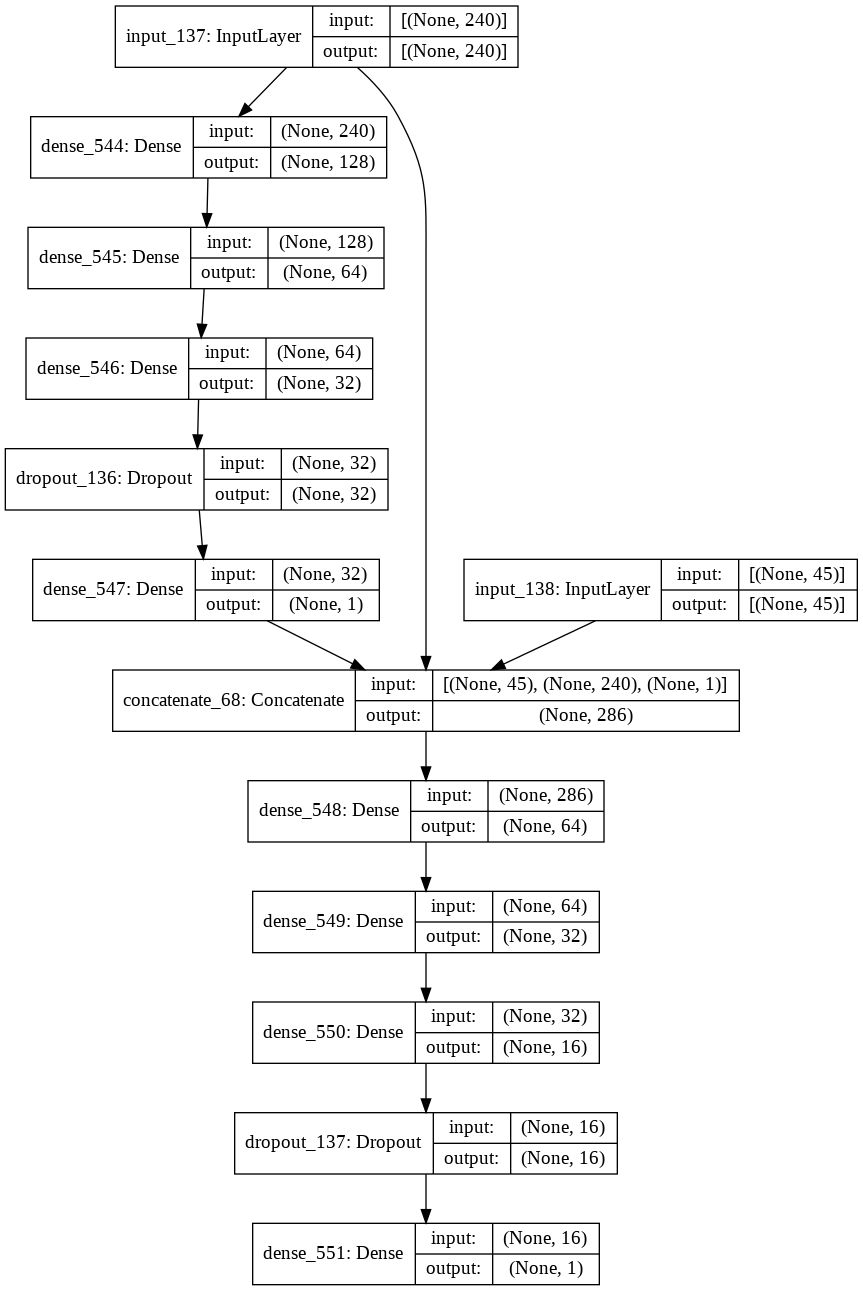

In [ ]:
from keras.utils.vis_utils import plot_model
model_3 = create_model()
plot_model(model_3, "model.png", show_shapes=True)

In [ ]:
#Create model for continuous inputs
input_layer = keras.layers.Input((binary_train_x.shape[1],))
hidden_1 = keras.layers.Dense(128, activation = "relu")(input_layer)
hidden_2 = keras.layers.Dense(64, activation = "relu")(hidden_1)
hidden_3 = keras.layers.Dense(64, activation = "relu")(hidden_2)
hidden_4 = keras.layers.Dense(64, activation = "relu")(hidden_3)
hidden_5 = keras.layers.Dense(32, activation = "relu")(hidden_4)
dropout_layer = keras.layers.Dropout(0.25)(hidden_5)
output_layer = keras.layers.Dense(1, "sigmoid")(dropout_layer)

#Compile model for continuous inputs
model_bin = keras.Model(input_layer, output_layer)
model_bin.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
histry_bin = model_bin.fit(binary_train_x.iloc[:100000,:], y_train.iloc[:100000], epochs = 50, batch_size = 32, callbacks = callbacks, verbose = 1, validation_data = (binary_val_x, y_val))

Epoch 1/50
3125/3125 [==============================] - 22s 7ms/step - loss: 0.5602 - accuracy: 0.7545 - val_loss: 0.5530 - val_accuracy: 0.7560
Epoch 2/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.5534 - accuracy: 0.7579 - val_loss: 0.5532 - val_accuracy: 0.7560
Epoch 3/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.5525 - accuracy: 0.7580 - val_loss: 0.5533 - val_accuracy: 0.7550
Epoch 4/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.5515 - accuracy: 0.7579 - val_loss: 0.5555 - val_accuracy: 0.7551
Epoch 5/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.5500 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7559
